In [1]:
from IPython.core.display import HTML
HTML("\n".join(open('mioti_style.css', 'r').readlines()))

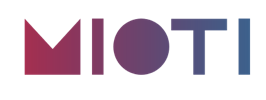
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S4: Predicción de precios AirBNB

## Objetivos

El objetivo de este challenge es predecir el precio de las viviendas de AirBnB Madrid a partir de alguna de sus características.

Este challenge utiliza un dataset real que no está pensado para aplicar técnicas de machine learning así que no esperes que las cosas funcionen bien a la primera 🤓.

## Configuración del entorno

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

## Dataset

Para este worksheet utilizaremos el dataset de airbnb Madrid.

In [3]:
df = pd.read_csv('dataset_airbnb_madrid.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13335 entries, 0 to 13334
Data columns (total 95 columns):
id                                  13335 non-null int64
listing_url                         13335 non-null object
scrape_id                           13335 non-null int64
last_scraped                        13335 non-null object
name                                13335 non-null object
summary                             12846 non-null object
space                               9700 non-null object
description                         13329 non-null object
experiences_offered                 13335 non-null object
neighborhood_overview               8308 non-null object
notes                               5037 non-null object
transit                             8264 non-null object
access                              7546 non-null object
interaction                         7523 non-null object
house_rules                         8666 non-null object
thumbnail_url                 

Para simplificar el problema vamos a formular el problema del challenge de una manera más concreta:

Vamos a intentar predecir el precio:

In [4]:
df['range'] = 0

In [5]:
df_y = df[['price', 'range']]

A partir de 5 variables que a priori parecen relevantes para determinar el precio de un alojamiento: `['review_scores_rating', 'room_type', 'property_type', 'bedrooms', 'bathrooms']`

Como siempre, si tu quieres considerar otras variables adelante.

In [6]:
df_X = df[['review_scores_rating', 'room_type', 'property_type', 'bedrooms', 'bathrooms' ]]

In [7]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13335 entries, 0 to 13334
Data columns (total 5 columns):
review_scores_rating    10417 non-null float64
room_type               13335 non-null object
property_type           13335 non-null object
bedrooms                13312 non-null float64
bathrooms               13285 non-null float64
dtypes: float64(3), object(2)
memory usage: 521.0+ KB


## Preprocesamiento de datos

Como siempre, vamos a inspeccionar y estudiar cada variable por separado.

### Price

Es la variable de clase. Divide esta variable en 4 rangos (muy bajo, bajo, medio, alto, muy alto) que pienses que son razonables para estudiar esta variable. Como consejo, quizás puedes utilizar los percentiles para hacer esta división.

Antes de hacer esta división revisa que esta variable esté codificada como un número, si no lo está la tendrás que convertir previamente.

Una vez que tengas la variable transformada, conviértela a un array de numpy para trabajar.

In [8]:
def float_price(row):
    try:
        row= row.replace(",", "")
        row = row.replace("$", "")
        row = float(row)
    except:
        row = np.nan
    return row

df_y['price'] = df_y['price'].apply(float_price)
df_y.describe()

price    range
count  13335.000000  13335.0
mean      69.162430      0.0
std      103.671918      0.0
min        9.000000      0.0
25%       31.000000      0.0
50%       53.000000      0.0
75%       80.000000      0.0
max     7700.000000      0.0

In [9]:
range = np.array(df_y['price'])

percentile = np.percentile(range, [2, 25, 50, 90])
percentile 

array([ 15.,  31.,  53., 120.])

In [10]:
def percentiles(row):
    if row <= 15:
        rango = 0 
    elif 15 < row < 31:
        rango = 1
    elif 31 < row < 53:
        rango = 2
    elif row > 120:
        rango = 4
    else:
        rango = 3
    return rango

df_y['range'] = df_y['price'].apply(percentiles)


df_y = df_y['range']
df_y

0        2
1        4
2        3
3        2
4        2
5        4
6        3
7        3
8        1
9        3
10       1
11       2
12       3
13       1
14       3
15       3
16       3
17       2
18       3
19       1
20       2
21       2
22       3
23       1
24       2
25       3
26       1
27       3
28       2
29       3
        ..
13305    4
13306    3
13307    2
13308    2
13309    3
13310    1
13311    1
13312    2
13313    2
13314    3
13315    2
13316    2
13317    1
13318    2
13319    3
13320    2
13321    4
13322    2
13323    2
13324    3
13325    3
13326    2
13327    2
13328    0
13329    2
13330    2
13331    2
13332    1
13333    2
13334    0
Name: range, Length: 13335, dtype: int64

### review_scores_rating

Esta variable parece un número. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Revisa el rango de la variable.

In [11]:
df_X['review_scores_rating'].head(16)

0      92.0
1      93.0
2      93.0
3      98.0
4     100.0
5      98.0
6      98.0
7      95.0
8       NaN
9      75.0
10    100.0
11     85.0
12     82.0
13     93.0
14    100.0
15      NaN
Name: review_scores_rating, dtype: float64

In [12]:
df_X['review_scores_rating'] = df.review_scores_rating.fillna(df.review_scores_rating.median())
df_X['review_scores_rating'].head(16)

0      92.0
1      93.0
2      93.0
3      98.0
4     100.0
5      98.0
6      98.0
7      95.0
8      94.0
9      75.0
10    100.0
11     85.0
12     82.0
13     93.0
14    100.0
15     94.0
Name: review_scores_rating, dtype: float64

### room_type

Esta variable parece un valor enumerado. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Si tiene muchos clases distintas piensa en reducirlas.

Una vez que esté bien crea variables ficticias a partir de esta.

In [13]:
df_X['room_type'].isnull().any()

False

In [14]:
df_X['room_type'].value_counts()

Entire home/apt    7935
Private room       5207
Shared room         193
Name: room_type, dtype: int64

In [15]:
df_X['room_type'] = df_X['room_type'].replace("Entire home/apt", 0)
df_X['room_type'] = df_X['room_type'].replace("Private room", 1)
df_X['room_type'] = df_X['room_type'].replace("Shared room", 2)

In [16]:
df_X['room_type'].value_counts()

0    7935
1    5207
2     193
Name: room_type, dtype: int64

### property_type

Esta variable parece un valor enumerado. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Si tiene muchos clases distintas piensa en reducirlas.

Una vez que esté bien crea variables ficticias a partir de esta.

In [17]:
df_X['property_type'].isnull().any()

False

In [18]:
df_X['property_type'].value_counts()

Apartment             10974
House                  1001
Condominium             346
Bed & Breakfast         339
Loft                    285
Other                   220
Dorm                     44
Guesthouse               39
Chalet                   24
Hostel                   16
Serviced apartment       13
Townhouse                 9
Boutique hotel            6
Villa                     4
Casa particular           3
Earth House               3
Guest suite               3
Camper/RV                 2
Bungalow                  1
Boat                      1
Tent                      1
Timeshare                 1
Name: property_type, dtype: int64

In [19]:
df_X['property_type'] = df_X['property_type'].replace('Apartment', 0)
df_X['property_type'] = df_X['property_type'].replace('Timeshare', 0)
df_X['property_type'] = df_X['property_type'].replace('House', 0)
df_X['property_type'] = df_X['property_type'].replace('Loft', 0)
df_X['property_type'] = df_X['property_type'].replace('Chalet', 0)
df_X['property_type'] = df_X['property_type'].replace('Townhouse', 0)
df_X['property_type'] = df_X['property_type'].replace('Villa', 0)
df_X['property_type'] = df_X['property_type'].replace('Condominium', 0)
df_X['property_type'] = df_X['property_type'].replace('Guest suite', 1)
df_X['property_type'] = df_X['property_type'].replace('Boutique hotel', 1)
df_X['property_type'] = df_X['property_type'].replace('Serviced apartment', 1)
df_X['property_type'] = df_X['property_type'].replace('Bed & Breakfast', 2)
df_X['property_type'] = df_X['property_type'].replace('Hostel', 2)
df_X['property_type'] = df_X['property_type'].replace('Dorm', 2)
df_X['property_type'] = df_X['property_type'].replace('Guesthouse', 2)
df_X['property_type'] = df_X['property_type'].replace('Earth House', 3)
df_X['property_type'] = df_X['property_type'].replace('Camper/RV', 3)
df_X['property_type'] = df_X['property_type'].replace('Tent', 3)
df_X['property_type'] = df_X['property_type'].replace('Boat', 3)
df_X['property_type'] = df_X['property_type'].replace('Bungalow', 3)
df_X['property_type'] = df_X['property_type'].replace('Other', 4)
df_X['property_type'] = df_X['property_type'].replace('Casa particular', 0)


### bedrooms

Esta variable parece un número. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Revisa el rango de la variable.

In [20]:
df_X['bedrooms'].isnull().any()

True

In [21]:
df_X['bedrooms'] = df_X.bedrooms.fillna(df_X.bedrooms.median())

In [22]:
df_X.bedrooms.describe()

count    13335.000000
mean         1.292988
std          0.824129
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: bedrooms, dtype: float64

### bathrooms

Esta variable parece un número. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Revisa el rango de la variable.

In [23]:
df_X.bathrooms.isnull().any()

True

In [24]:
df_X['bathrooms'] = df_X.bathrooms.fillna(df_X.bathrooms.median())

### Chequeos finales y conversión a numpy

Una vez que hemos revisado cada variable hacemos algunas comprobaciones finales:

In [25]:
df_X.isnull().any()

review_scores_rating    False
room_type               False
property_type           False
bedrooms                False
bathrooms               False
dtype: bool

In [26]:
df_X.tail()

review_scores_rating  room_type  property_type  bedrooms  bathrooms
13330                  97.0          1              2       2.0        1.0
13331                 100.0          1              0       1.0        1.0
13332                  94.0          1              0       1.0        1.0
13333                 100.0          0              0       1.0        1.0
13334                  94.0          1              0       1.0        1.0

Y convertimos a un array de `numpy`:

In [27]:
dataset_X = np.array(df_X)

In [28]:
dataset_X.shape

(13335, 5)

In [29]:
dataset_X

array([[ 92.,   1.,   0.,   1.,   2.],
       [ 93.,   0.,   0.,   3.,   1.],
       [ 93.,   0.,   0.,   1.,   1.],
       ...,
       [ 94.,   1.,   0.,   1.,   1.],
       [100.,   0.,   0.,   1.,   1.],
       [ 94.,   1.,   0.,   1.,   1.]])

## Conjunto de entrenamiento y test

Crea un conjunto de entrenamiento y test con una proporción del 30%.

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_X, df_y, test_size=.3, random_state=42)

## Entrenamiento y clasificación

Utiliza un RandomForest como algoritmo de clasificación y entrena el modelo.

In [31]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()

In [32]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Evalua el modelo

Calcula score, ROC y matriz de confusión

In [33]:
from sklearn import tree 
random_forest.predict_proba(X_test)

array([[0.        , 0.00370905, 0.13874331, 0.68795021, 0.16959742],
       [0.        , 0.06485764, 0.28783506, 0.58277163, 0.06453566],
       [0.        , 0.07055704, 0.31596701, 0.59193744, 0.02153851],
       ...,
       [0.        , 0.66617965, 0.26715368, 0.06666667, 0.        ],
       [0.06369991, 0.46381517, 0.29407183, 0.11301602, 0.06539707],
       [0.        , 0.        , 0.        , 1.        , 0.        ]])

In [34]:
random_forest.score(X_test, y_test)

0.6038490377405649

El porcentaje de acierto es del 60%. A continuación podemos ver las curvas ROC.

In [35]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_test, random_forest.predict_proba(X_test))
plt.show()

Matriz de confusión

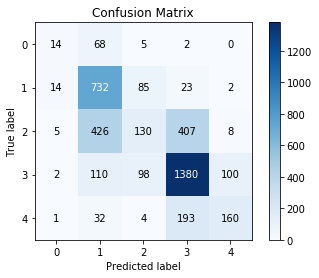

In [36]:
import scikitplot as skplt
y_predicted = random_forest.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_predicted)

In [37]:
y_predicted

array([3, 3, 3, ..., 1, 1, 3])

### Preguntas

* ¿Consideras que los resultados son buenos o malos?
* Qué podemos hacer para mejorarlo?

En mi opinión no hemos obtenido muy buenos resultados por diferentes motivos:
    - El porcentaje de acierto es bastante bajo (60%).
    - Aunque el área de las curvas ROC se acerca bastante a 1 (exceptuando la clase 2 - Medio), valor que define la separabilidad de las clases, se observa que todas las curvas están prácticamente solapadas, lo que inducirá un error en nuestra predicción.
    - En la Matriz de confusion podemos observar que nuestro clasificador obtiene el mayor número de aciertos cuando se trata de clasificar clase 1 (bajo) y clase 3 (alto); mientras que para el resto de casos el margen de error es muy elevado (se observa sobre todo en el caso de la clase 0 y 2).
    

Se podría probar eliminando variables que no aportan mucho valor o cambiando la clasificación de estas; ya que quizás no se han dividido de la mejor manera. En mi caso, he dividido el tipo de propiedad por parecido - casas particulares, alojamientos en el aire libre, hoteles y parecidos. Por tanto, se podría clasificar en función de lo que suele costar una u otra cosa para así tener un resultado más ajustado.

## Análisis de variables (extra)

Algunos métodos incluyen una variable denominada `feature_importances_` que nos proporciona una estimación de la importancia de esa variable.

Analiza las variables, su importancia y propone maneras para mejorar el dataset.

In [37]:
print(random_forest.feature_importances_)

[0.20333232 0.51970047 0.02358235 0.11024308 0.14314178]


Una opción para mejorarlo podría ser hacer una clasificación menor en el precio y dejarlo a Alto, Medio, Bajo - ya que así podríamos aumentar los aciertos en la predicción. 